In [1]:
import numpy as np
import matplotlib.pylab as plt
from astropy.time import Time
from pulsar.predictor import Polyco

from baseband import mark5b
from baseband import vdif
import astropy.units as u
from pulsar.predictor import Polyco

%matplotlib inline

In [2]:
def phase(x, m, b):
    return (m*x+b) % (2*np.pi) - np.pi

def lsq(data, model):
    return np.median((data - model)**2.0)

def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def dechannelize(pulse):
    pulse = np.fft.irfft(pulse, axis=1)
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, pulse.shape[-1])
    else:
        pulse = pulse.ravel()
    return pulse

def channelize_ts(pulse, nchan):
    if len(pulse.shape) == 2:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def correlate(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine / abs(p1fine)) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def correlate_power(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def power(dchan):
    dR = np.concatenate((dchan[:,::-1,8], dchan[...,0], dchan[:,::-1,10], dchan[...,2], dchan[:,::-1,12], dchan[...,4], dchan[:,::-1,14], dchan[...,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[...,1], dchan[:,::-1,11], dchan[...,3], dchan[:,::-1,13], dchan[...,5], dchan[:,::-1,15], dchan[...,7]), axis=1)
    power = (abs(dR)**2 + abs(dL)**2)
    return power

def stitch(dchan):
    dR = np.concatenate((dchan[:,::-1,8][:,:-1], dchan[:,:-1,0], dchan[:,::-1,10][:,:-1], dchan[:,:-1,2], 
                         dchan[:,::-1,12][:,:-1], dchan[:,:-1,4], dchan[:,::-1,14][:,:-1], dchan[:,:-1,6]), axis=1)
    dL = np.concatenate((dchan[:,::-1,9], dchan[:,:,1], dchan[:,::-1,11], dchan[:,:,3], 
                         dchan[:,::-1,13], dchan[:,:,5], dchan[:,::-1,15], dchan[:,:,7]), axis=1)
    return dR, dL
    
def powerchan(dchan):
    R = np.array([8,0,10,2,12,4,14,6])
    L = np.array([9,1,11,2,13,5,15,7])
    dR = dchan[...,R]
    dL = dchan[...,L]
    power = abs(dR)**2.0 + abs(dL)**2.0
    return power

def normpower(pulse):
    p1temp = rechannelize(pulse, 256)
    power1 = abs(p1temp)**2.0
    power1 = power1[16] - power1[2:12].mean(axis=0)
    power1 = power1[32:-32]
    power1 = (power1 - power1.mean(axis=0)) / power1.std(axis=0)
    return power1
    

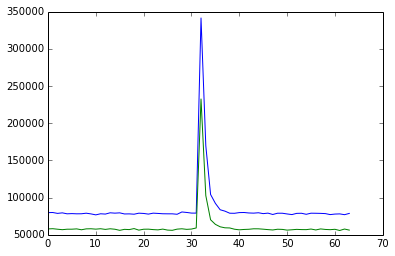

In [38]:
%matplotlib inline
t_gp = '2015-10-19T00:17:47.415'
#t_gp = '2015-10-18T23:41:53.277'
#t_gp = '2015-10-18T23:39:46.844'
#t_gp = '2015-10-19T00:54:59.880'

p1 = np.load('GPjb/p%s.npy' % (t_gp))
p2 = np.load('GPsv/p%s.npy' % (t_gp))

m = np.mean(abs(p1).sum(-1).sum(-1)[:26])

plt.plot(abs(p1).sum(-1).sum(-1))
plt.plot(abs(p2).sum(-1).sum(-1))

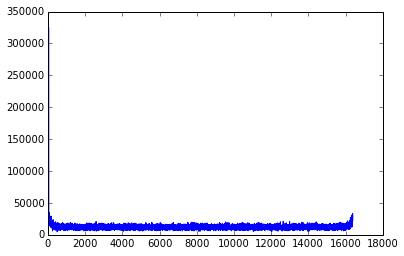

In [39]:
"""
Shift timestreams to closest sample

De-channelize, fit for corr peak, then shift
"""
%matplotlib inline

nchan = 32

p1d = dechannelize(p1)
p2d = dechannelize(p2)

ftcorr = (np.fft.rfft(p1d,axis=0) * np.conj(np.fft.rfft(p2d, axis=0)))
#pad = np.zeros_like(ftcorr)
#ftcorr = np.concatenate((ftcorr,pad))
#pad = np.zeros_like(ftcorr)
#ftcorr = np.concatenate((ftcorr,pad))
#pad = np.zeros_like(ftcorr)
#ftcorr = np.concatenate((ftcorr,pad))

corr = np.fft.irfft(ftcorr, axis=0)
sampdelay = np.argmax(abs(corr).sum(-1))
p2d = np.roll(p2d, sampdelay, axis=0)

p2 = channelize_ts(p2d, nchan)
p1 = rechannelize(p1, nchan)

#plt.plot(abs(p1).sum(-1).sum(-1))
#plt.plot(abs(p2).sum(-1).sum(-1))
plt.plot(abs(corr).sum(-1))

-0.144802867801 0.951997773815


(-6.283185307179586, 6.283185307179586)

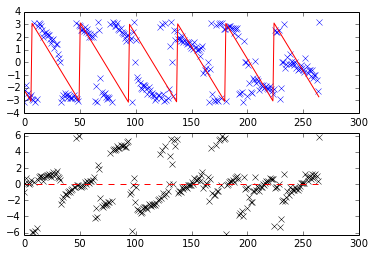

In [40]:
"""
Do a quick grid search of the best fit parameters

Uses the median of deviations to minimize, less sensitive to ~2pi wrapping outliers
"""

p1R, p1L = stitch(p1)
p2R, p2L = stitch(p2)

mask = np.linspace(0,8,8)*nchan

corr = np.fft.ifft( (np.fft.fft(p1R,axis=0) * np.conj(np.fft.fft(p2R, axis=0))), axis=0)

#data = np.angle(corr[0,3:-3, 2])
data = np.angle(corr[0])
data[0:nchan] = np.angle(np.conj(corr[0,:nchan]))
data[2*nchan:3*nchan] = np.angle(np.conj(corr[0,2*nchan:3*nchan]))
data[4*nchan:5*nchan] = np.angle(np.conj(corr[0,4*nchan:5*nchan]))
data[6*nchan:7*nchan] = np.angle(np.conj(corr[0,6*nchan:7*nchan]))

brange = np.linspace(0,2*np.pi,100)
mrange = np.linspace(-np.pi,np.pi,500)
x = np.linspace(0,len(data), len(data))

#data = np.delete(data, mask)
#x = np.delete(x, mask)

minfit = 1e10
for b in brange:
    for m in mrange:
        model = phase(x, m, b)
        mintemp = lsq(data, model)
        if mintemp < minfit:
            minfit = mintemp
            mbest = m
            bbest = b
            
print mbest, bbest

plt.subplot(211)
plt.plot(x, data, 'bx')
plt.plot(x, phase(x, mbest, bbest), 'r')

plt.subplot(212)
plt.plot(x, data-phase(x,mbest,bbest), 'kx')
plt.plot(x,0*x, 'r--')
plt.ylim(-2*np.pi, 2*np.pi)

(120, 180)

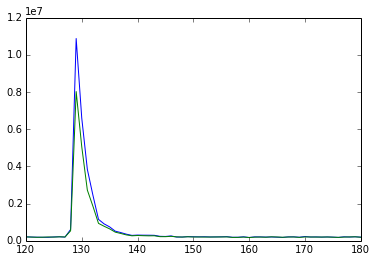

In [41]:
"""
Correct conjugates and sum incoherently
"""

pmodel = phase(x,mbest,bbest)
pmodel[0:nchan] *= -1
pmodel[2*nchan:3*nchan] *= -1
pmodel[4*nchan:5*nchan] *= -1
pmodel[6*nchan:7*nchan] *= -1

p2derot = p2R*np.exp(1j*pmodel)[np.newaxis,...]

pRsum = abs(p1R + p2derot)**2.0
pincoh = abs(p1R)**2.0 + abs(p2R)**2.0

plt.plot(pRsum.sum(-1))
plt.plot(pincoh.sum(-1))

plt.xlim(120,180)

0.0692535454699 3.10985939446


(-6.283185307179586, 6.283185307179586)

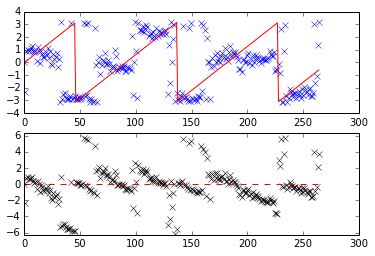

In [42]:
"""
Do a quick grid search of the best fit parameters

Uses the median of deviations to minimize, less sensitive to ~2pi wrapping outliers
"""

p1R, p1L = stitch(p1)
p2R, p2L = stitch(p2)

mask = np.linspace(0,8,8)*nchan

corr = np.fft.ifft( (np.fft.fft(p1L,axis=0) * np.conj(np.fft.fft(p2L, axis=0))), axis=0)

#data = np.angle(corr[0,3:-3, 2])
data = np.angle(corr[0])
data[0:nchan] = np.angle(np.conj(corr[0,:nchan]))
data[2*nchan:3*nchan] = np.angle(np.conj(corr[0,2*nchan:3*nchan]))
data[4*nchan:5*nchan] = np.angle(np.conj(corr[0,4*nchan:5*nchan]))
data[6*nchan:7*nchan] = np.angle(np.conj(corr[0,6*nchan:7*nchan]))

brange = np.linspace(0,2*np.pi,100)
mrange = np.linspace(-np.pi,np.pi,500)
x = np.linspace(0,len(data), len(data))

#data = np.delete(data, mask)
#x = np.delete(x, mask)

minfit = 1e10
for b in brange:
    for m in mrange:
        model = phase(x, m, b)
        mintemp = lsq(data, model)
        if mintemp < minfit:
            minfit = mintemp
            mbest = m
            bbest = b
            
print mbest, bbest

plt.subplot(211)
plt.plot(x, data, 'bx')
plt.plot(x, phase(x, mbest, bbest), 'r')

plt.subplot(212)
plt.plot(x, data-phase(x,mbest,bbest), 'kx')
plt.plot(x,0*x, 'r--')
plt.ylim(-2*np.pi, 2*np.pi)

(120, 180)

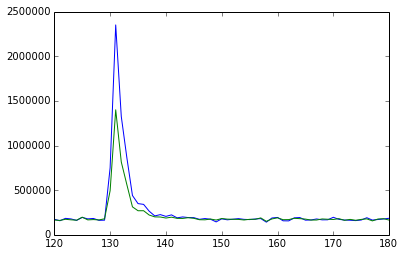

In [25]:
pmodel = phase(x,mbest,bbest)
pmodel[0:nchan] *= -1
pmodel[2*nchan:3*nchan] *= -1
pmodel[4*nchan:5*nchan] *= -1
pmodel[6*nchan:7*nchan] *= -1

p2derot = p2L*np.exp(1j*pmodel)[np.newaxis,...]

pLsum = abs(p1L + p2derot)**2.0
pincoh = abs(p1L)**2.0 + abs(p2L)**2.0

plt.plot(pLsum.sum(-1))
plt.plot(pincoh.sum(-1))

plt.xlim(120,180)

In [43]:
"""
Select telescope list, phase all pulses
"""

#t_gp = '2015-10-19T00:17:47.415'
t_gp = '2015-10-19T00:54:59.880'

tel1 = 'ef'
#tels = ['sr']
tels = ['jb','wb','hh','bd','sr', 'o8', 'mc', 'sv', 'zc', 'tr', 't6']
p1 = np.load('GP%s/p%s.npy' % (tel1, t_gp))
switch = 0

for tel in tels:

    p2 = np.load('GP%s/p%s.npy' % (tel, t_gp))
    
    """
    Shift timestreams to closest sample

    De-channelize, fit for corr peak, then shift
    """

    nchan = 32

    p1d = dechannelize(p1)
    p2d = dechannelize(p2)

    corr = np.fft.irfft( (np.fft.rfft(p1d,axis=0) * np.conj(np.fft.rfft(p2d, axis=0))), axis=0)
    sampdelay = np.argmax(abs(corr).sum(-1))
    p2d = np.roll(p2d, sampdelay, axis=0)

    p2 = channelize_ts(p2d, nchan)
    p1 = rechannelize(p1, nchan)

    """
    Do a quick grid search of the best fit parameters

    Uses the median of deviations to minimize, less sensitive to ~2pi wrapping outliers
    """

    p1R, p1L = stitch(p1)
    p2R, p2L = stitch(p2)

    if switch == 0:
        pRsum = 1.*p1R
        pincoh = abs(p1R)**2.0
        switch = 1
    
    mask = np.linspace(0,8,8)*nchan

    corr = np.fft.ifft( (np.fft.fft(p1R,axis=0) * np.conj(np.fft.fft(p2R, axis=0))), axis=0)

    data = np.angle(corr[0])
    data[0:nchan] = np.angle(np.conj(corr[0,:nchan]))
    data[2*nchan:3*nchan] = np.angle(np.conj(corr[0,2*nchan:3*nchan]))
    data[4*nchan:5*nchan] = np.angle(np.conj(corr[0,4*nchan:5*nchan]))
    data[6*nchan:7*nchan] = np.angle(np.conj(corr[0,6*nchan:7*nchan]))

    brange = np.linspace(0,2*np.pi,100)
    mrange = np.linspace(-np.pi,np.pi,500)
    x = np.linspace(0,len(data), len(data))

    minfit = 1e10
    for b in brange:
        for m in mrange:
            model = phase(x, m, b)
            mintemp = lsq(data, model)
            if mintemp < minfit:
                minfit = mintemp
                mbest = m
                bbest = b

    """
    Correct conjugates and sum incoherently
    """

    pmodel = phase(x,mbest,bbest)
    pmodel[0:nchan] *= -1
    pmodel[2*nchan:3*nchan] *= -1
    pmodel[4*nchan:5*nchan] *= -1
    pmodel[6*nchan:7*nchan] *= -1

    p2derot = p2R*np.exp(1j*pmodel)[np.newaxis,...]

    pRsum += p2derot
    pincoh += abs(p2R)**2.0

In [1]:
"""
Select telescope list, phase all pulses
"""

#t_gp = '2015-10-19T00:17:47.415'
t_gp = '2015-10-19T00:54:59.880'

tel1 = 'ef'
#tels = ['sr']
#tels = ['jb','wb','hh','bd', 'sr', 'o8', 'mc', 'sv', 'zc']
tels = ['jb','wb','sr']
p1 = np.load('GP%s/p%s.npy' % (tel1, t_gp))
switch = 0

for tel in tels:

    p2 = np.load('GP%s/p%s.npy' % (tel, t_gp))
    
    """
    Shift timestreams to closest sample

    De-channelize, fit for corr peak, then shift
    """

    nchan = 32

    p1d = dechannelize(p1)
    p2d = dechannelize(p2)

    corr = np.fft.irfft( (np.fft.rfft(p1d,axis=0) * np.conj(np.fft.rfft(p2d, axis=0))), axis=0)
    sampdelay = np.argmax(abs(corr).sum(-1))
    p2d = np.roll(p2d, sampdelay, axis=0)

    p2 = channelize_ts(p2d, nchan)
    p1 = rechannelize(p1, nchan)

    """
    Do a quick grid search of the best fit parameters

    Uses the median of deviations to minimize, less sensitive to ~2pi wrapping outliers
    """

    p1R, p1L = stitch(p1)
    p2R, p2L = stitch(p2)

    if switch == 0:
        pLsum = 1.*p1L
        pincoh = abs(p1L)**2.0
        switch = 1
    
    mask = np.linspace(0,8,8)*nchan

    corr = np.fft.ifft( (np.fft.fft(p1L,axis=0) * np.conj(np.fft.fft(p2L, axis=0))), axis=0)

    data = np.angle(corr[0])
    data[0:nchan] = np.angle(np.conj(corr[0,:nchan]))
    data[2*nchan:3*nchan] = np.angle(np.conj(corr[0,2*nchan:3*nchan]))
    data[4*nchan:5*nchan] = np.angle(np.conj(corr[0,4*nchan:5*nchan]))
    data[6*nchan:7*nchan] = np.angle(np.conj(corr[0,6*nchan:7*nchan]))

    brange = np.linspace(0,2*np.pi,100)
    mrange = np.linspace(-np.pi,np.pi,500)
    x = np.linspace(0,len(data), len(data))

    minfit = 1e10
    for b in brange:
        for m in mrange:
            model = phase(x, m, b)
            mintemp = lsq(data, model)
            if mintemp < minfit:
                minfit = mintemp
                mbest = m
                bbest = b

    """
    Correct conjugates and sum incoherently
    """

    pmodel = phase(x,mbest,bbest)
    pmodel[0:nchan] *= -1
    pmodel[2*nchan:3*nchan] *= -1
    pmodel[4*nchan:5*nchan] *= -1
    pmodel[6*nchan:7*nchan] *= -1

    p2derot = p2L*np.exp(1j*pmodel)[np.newaxis,...]

    pLsum += p2derot
    pincoh += abs(p2L)**2.0

NameError: name 'np' is not defined

(120, 180)

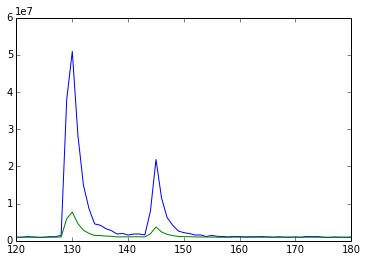

In [51]:
%matplotlib qt
plt.plot((abs(pRsum)**2.0).sum(-1))
plt.plot(pincoh.sum(-1))

plt.xlim(120,180)

(256, 264)


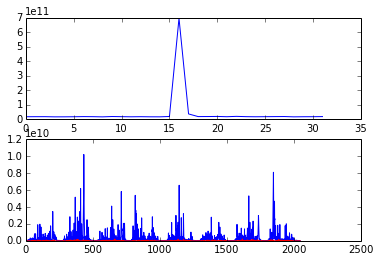

In [50]:
print pRsum.shape

test = np.delete(pLsum, np.linspace(0,8,8)*(nchan+1), axis=1)

pfine = rechannelize(test, 256*8)

%matplotlib qt
plt.subplot(211)
plt.plot((abs(pfine)**2.0).sum(-1))

plt.subplot(212)
plt.plot(abs(pfine[16])**2.0)
plt.plot(abs(pfine[18])**2.0, 'r')

In [66]:
#corrb = 1.*np.array(corr)
corr = []
corrb = []

p1t = abs(pfine[16])**2.0
p2t = abs(pfine[18])**2.0
p1b = abs(pfine[14])**2.0
p2b = abs(pfine[20])**2.0


for i in range(len(p1t)):
    p2temp = np.roll(p2t, i)
    b2temp = np.roll(p2b, i)
    corr.append(np.sum(p1t*p2temp))
    corrb.append(np.sum(p1b*b2temp))

%matplotlib qt
corr = np.array(corr)
corrb = np.array(corrb)

plt.plot(np.roll(corr, 1024))
plt.plot(np.roll(corrb, 1024) * 50, 'r')


In [67]:
p1 = test[127:127+16]
p2 = test[142:142+16]

print(p1.shape)

c = correlate_power(p1,p2,32*8,256*8)

%matplotlib qt
plt.plot(abs(c).sum(-1))
#plt.plot(abs(p1).sum(-1))
#plt.plot(abs(p2).sum(-1))

(16, 257)


In [17]:
T = Time(np.loadtxt('/home/ramain/packages/scint_analysis/EVN_crab/all7_sorted.txt',dtype='string')[:,0])
SN = np.loadtxt('/home/ramain/packages/scint_analysis/EVN_crab/all7_sorted.txt', dtype='string')[:,1].astype('float')

Tphase = T[SN > 20]
print Tphase
print mbest

['2015-10-18T23:21:58.347' '2015-10-18T23:27:23.667'
 '2015-10-18T23:41:53.277' '2015-10-18T23:46:10.046'
 '2015-10-18T23:49:17.214' '2015-10-18T23:50:30.066'
 '2015-10-18T23:55:38.899' '2015-10-19T00:17:47.415'
 '2015-10-19T00:18:03.294' '2015-10-19T00:22:00.962'
 '2015-10-19T00:22:00.962' '2015-10-19T00:22:09.794'
 '2015-10-19T00:35:34.934' '2015-10-19T00:35:39.688'
 '2015-10-19T00:36:52.101' '2015-10-19T00:38:03.367'
 '2015-10-19T00:42:01.609' '2015-10-19T00:47:13.915'
 '2015-10-19T00:50:40.974' '2015-10-19T00:54:59.880'
 '2015-10-19T00:58:18.308' '2015-10-19T01:17:00.441'
 '2015-10-19T01:22:21.849' '2015-10-19T01:23:57.220'
 '2015-10-19T01:35:58.654' '2015-10-19T01:49:09.702'
 '2015-10-19T02:02:36.764' '2015-10-19T02:11:32.378'
 '2015-10-19T02:16:27.626' '2015-10-19T02:29:55.531'
 '2015-10-19T02:30:20.444' '2015-10-19T02:32:25.818'
 '2015-10-19T02:35:26.143' '2015-10-19T02:44:06.081'
 '2015-10-19T02:50:01.673']
0.0314788843045


In [ ]:
"""
Select telescope list, and giant pulse time list 

calculate time offset for each pair
"""

tel1 = 'ef'
tels = ['jb']
#tels = ['jb','wb','hh','bd', 'sr', 'o8']

tphase = 7.8125 # (ns per radian phase)
tsamp = 62.5 # (ns per sample)


toffset = []

for t_gp in Tphase:
    
    p1 = np.load('GP%s/p%s.npy' % (tel1, t_gp))
    switch = 0
    
    for tel in tels:

        p2 = np.load('GP%s/p%s.npy' % (tel, t_gp))

        """
        Shift timestreams to closest sample

        De-channelize, fit for corr peak, then shift
        """

        nchan = 32

        p1d = dechannelize(p1)
        p2d = dechannelize(p2)

        corr = np.fft.irfft( (np.fft.rfft(p1d,axis=0) * np.conj(np.fft.rfft(p2d, axis=0))), axis=0)
        sampdelay = np.argmax(abs(corr).sum(-1))
        p2d = np.roll(p2d, sampdelay, axis=0)

        p2 = channelize_ts(p2d, nchan)
        p1 = rechannelize(p1, nchan)

        """
        Do a quick grid search of the best fit parameters

        Uses the median of deviations to minimize, less sensitive to ~2pi wrapping outliers
        """

        p1R, p1L = stitch(p1)
        p2R, p2L = stitch(p2)

        if switch == 0:
            pRsum = 1.*p1R
            pincoh = abs(p1R)**2.0
            switch = 1

        corr = np.fft.ifft( (np.fft.fft(p1R,axis=0) * np.conj(np.fft.fft(p2R, axis=0))), axis=0)

        data = np.angle(corr[0])
        data[0:nchan] = np.angle(np.conj(corr[0,:nchan]))
        data[2*nchan:3*nchan] = np.angle(np.conj(corr[0,2*nchan:3*nchan]))
        data[4*nchan:5*nchan] = np.angle(np.conj(corr[0,4*nchan:5*nchan]))
        data[6*nchan:7*nchan] = np.angle(np.conj(corr[0,6*nchan:7*nchan]))

        brange = np.linspace(0,2*np.pi,100)
        mrange = np.linspace(-np.pi,np.pi,100)
        x = np.linspace(0,len(data), len(data))

        minfit = 1e10
        for b in brange:
            for m in mrange:
                model = phase(x, m, b)
                mintemp = lsq(data, model)
                if mintemp < minfit:
                    minfit = mintemp
                    mbest = m
                    bbest = b
        
        toff = sampdelay*tsamp + mbest*tphase 
        toffset.append(toff)
        
        """
        Correct conjugates and sum incoherently
        """

        pmodel = phase(x,mbest,bbest)
        pmodel[0:nchan] *= -1
        pmodel[2*nchan:3*nchan] *= -1
        pmodel[4*nchan:5*nchan] *= -1
        pmodel[6*nchan:7*nchan] *= -1

        p2derot = p2R*np.exp(1j*pmodel)[np.newaxis,...]

        pRsum += p2derot
        pincoh += abs(p2R)**2.0

    #plt.plot((abs(pRsum)**2.0).sum(-1))
    #plt.plot(pincoh.sum(-1))

In [22]:
%matplotlib qt
plt.plot(Tphase.unix-Tphase.unix[0], toffset)

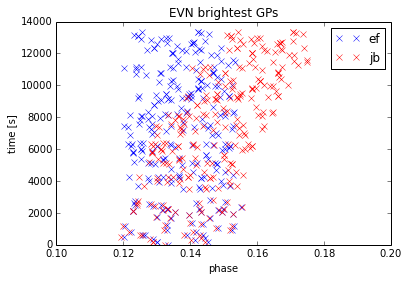

In [3]:
"""
Load EVN pulse list, calculate phases
"""

T = Time(np.loadtxt('/home/ramain/packages/scint_analysis/EVN_crab/all7_sorted.txt',dtype='string')[:,0])
SN = np.loadtxt('/home/ramain/packages/scint_analysis/EVN_crab/all7_sorted.txt', dtype='string')[:,1].astype('float')

ef_polyco = Polyco('/home/ramain/packages/scint_analysis/EVN_crab/oct_polycob0531_eff.dat')
jb_polyco = Polyco('/home/ramain/packages/scint_analysis/EVN_crab/oct_polycob0531_jb.dat')
wb_polyco = Polyco('/home/ramain/packages/scint_analysis/EVN_crab/oct_polycob0531_wsrt.dat')
#psr_polyco = Polyco('/home/ramain/Ephemerides/Crab-Old/polyco_new.dat')
phase_pol = ef_polyco.phasepol(T[0])
ef_phase = np.remainder(phase_pol(T.mjd), 1)

phase_pol = jb_polyco.phasepol(T[0])
jb_phase = np.remainder(phase_pol(T.mjd), 1)

phase_pol = wb_polyco.phasepol(T[0])
wb_phase = np.remainder(phase_pol(T.mjd), 1)

"""
Plot phase vs. Time
"""

%matplotlib inline

plt.plot(ef_phase, T.unix-T[0].unix, 'bx', label='ef')
plt.plot(jb_phase, T.unix-T[0].unix, 'rx', label='jb')

plt.ylabel('time [s]')
plt.xlabel('phase')

plt.xlim(0.1,0.2)
plt.legend()
plt.title('EVN brightest GPs')

In [186]:
%matplotlib qt
pdiff = jb_phase-ef_phase
Tdiff = T.unix-T[0].unix

plt.plot(T.unix-T[0].unix, (jb_phase-ef_phase) )
#plt.plot(T.unix-T[0].unix, (wb_phase-ef_phase) )
plt.ylabel('phase difference')
plt.xlabel('time [s]')

In [5]:
def read_baseband(t_gp, tel):

    st = Time(np.loadtxt('starttimes.txt', dtype='string'))

    for i in range(len(st)):
        if t_gp.unix > st[i].unix:
            findex = i+1

    fn = 'ef_data/{0}/ek036a_{0}_no{1:04d}.m5a'.format(tel, findex)

    size = 2 ** 20
    sample_rate = 32 * u.MHz
    dt1 = 1/sample_rate
    thread_ids = [0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15]
    fedge = 1610.49 * u.MHz + ((np.linspace(0,15,16) % 8) // 2) * 32. * u.MHz
    fref = fedge.mean() + sample_rate / 4
    nchan = 512
    # October DM from JB ephemeris (1e-2 is by eye correction)
    dm = (56.7957 + 1e-2) * u.pc / u.cm**3
    #dm = 0

    class DispersionMeasure(u.Quantity):

        dispersion_delay_constant = 4149. * u.s * u.MHz**2 * u.cm**3 / u.pc
        _default_unit = u.pc / u.cm**3

        def __new__(cls, dm, unit=None, dtype=None, copy=True):
            if unit is None:
                unit = getattr(dm, 'unit', cls._default_unit)
            self = super(DispersionMeasure, cls).__new__(cls, dm, unit,
                                                         dtype=dtype, copy=copy)
            if not self.unit.is_equivalent(cls._default_unit):
                raise u.UnitsError("Dispersion measures should have units of "
                                   "pc/cm^3")
            return self

        def __quantity_subclass__(self, unit):
            if unit.is_equivalent(self._default_unit):
                return DispersionMeasure, True
            else:
                return super(DispersionMeasure,
                             self).__quantity_subclass__(unit)[0], False

        def __call__(self, f, fref, kind='complex'):
            d = self.dispersion_delay_constant * self
            if kind == 'delay':
                return d * (1./f**2 - 1./fref**2)
            else:
                dang = (d * f * (1./fref-1./f)**2) * u.cycle
                if kind == 'phase':
                    return dang
                elif kind == 'complex':
                    return np.exp(dang.to(u.rad).value * 1j)

            raise ValueError("kind not one of 'delay', 'phase', or 'complex'")

    dm = DispersionMeasure(dm)

    if tel == 'sr' or tel == 'mc':
        fh = vdif.open(fn, mode='rs', sample_rate=sample_rate)
    else:
        fh = mark5b.open(fn, mode='rs', nchan=16,
                        sample_rate=sample_rate, thread_ids=thread_ids, ref_mjd=57000)
    offset_gp = ((t_gp - fh.tell(unit='time')).to(u.s).value *
                 fh.frames_per_second * fh.samples_per_frame)
    fh.seek(int(offset_gp) - size // 2)
    d = fh.read(size)
    if tel == 'sr' or tel == 't6' or tel =='tr':
        d = np.roll(d, 8, axis=-1)
    if tel == 'mc' or tel =='sr':
        d = d[:,thread_ids]        
    ft = np.fft.rfft(d, axis=0)
    # Second half of IFs have Fedge at top, need to subtract frequencies, 
    # and not conjugate coherent phases
    f = fedge + np.fft.rfftfreq(d.shape[0], dt1)[:, np.newaxis]
    f[:,8:] = fedge[8:] - np.fft.rfftfreq(d.shape[0], dt1)[:, np.newaxis]
    ft[:,:8] *= dm(f[:,:8], fref, kind='complex').conj()
    ft[:,8:] *= dm(f[:,8:], fref, kind='complex')
    d = np.fft.irfft(ft, axis=0)

    # Channelize the data
    dchan = np.fft.rfft(d.reshape(-1, 2*nchan, 16), axis=1)

    return dchan

In [183]:
def shift_phase(p1,p2,nchan):

    peak1 = np.argmax(abs(p1).sum(-1).sum(-1))
    peak2 = np.argmax(abs(p2).sum(-1).sum(-1))
    # Incoherent shift is beneficial
    p2 = np.roll(p2, peak1-peak2, axis=0)
    
    p1d = dechannelize(p1[peak1-10:peak1+10])
    p2d = dechannelize(p2[peak1-10:peak1+10])

    ftcorr = (np.fft.rfft(p1d,axis=0) * np.conj(np.fft.rfft(p2d, axis=0)))

    corr = np.fft.irfft(ftcorr, axis=0)
    
    plt.subplot(411)
    plt.plot(abs(corr).sum(-1))
    plt.xlabel('lag [samples]')
    plt.ylabel('visibility |EfxJb*|')
    
    sampdelay = np.argmax(abs(corr).sum(-1))
    len_ts = p2d.shape[0]    
    p2d = np.roll(p2d, sampdelay, axis=0)
    if len_ts-sampdelay < sampdelay:
        sampdelay = -(len_ts - sampdelay)
    
    p2 = channelize_ts(p2d, nchan)
    p1 = rechannelize(p1[peak1-10:peak1+10], nchan)

    
    """
    Do a quick grid search of the best fit parameters

    Uses the median of deviations to minimize, less sensitive to ~2pi wrapping outliers
    """

    p1R, p1L = stitch(p1)
    p2R, p2L = stitch(p2)

    peak = np.argmax(abs(p1R).sum(-1))
    p1R = p1R[peak-50:peak+50]
    p2R = p2R[peak-50:peak+50]

    mask = np.linspace(0,8,8)*nchan

    corr = np.fft.ifft( (np.fft.fft(p1R,axis=0) * np.conj(np.fft.fft(p2R, axis=0))), axis=0)
    
    data = np.angle(corr[0])
    data[0:nchan] = np.angle(np.conj(corr[0,:nchan]))
    data[2*nchan:3*nchan] = np.angle(np.conj(corr[0,2*nchan:3*nchan]))
    data[4*nchan:5*nchan] = np.angle(np.conj(corr[0,4*nchan:5*nchan]))
    data[6*nchan:7*nchan] = np.angle(np.conj(corr[0,6*nchan:7*nchan]))

    brange = np.linspace(0,2*np.pi,100)
    mrange = np.linspace(-np.pi,np.pi,500)
    x = np.linspace(0,len(data), len(data))

    #data = np.delete(data, mask)
    #x = np.delete(x, mask)

    minfit = 1e10
    for b in brange:
        for m in mrange:
            model = phase(x, m, b)
            mintemp = lsq(data, model)
            if mintemp < minfit:
                minfit = mintemp
                mbest = m
                bbest = b

    plt.subplot(412)
    plt.plot(x, data, 'bx')
    plt.plot(x, phase(x, mbest, bbest), 'r')
    plt.xlabel('frequency [bins]')
    plt.ylabel('phase [radians]')
    
    plt.subplot(413)
    plt.plot(x, data-phase(x,mbest,bbest), 'kx')
    plt.plot(x,0*x, 'r--')
    plt.ylim(-2*np.pi, 2*np.pi)
    
    plt.xlabel('frequency [bins]')
    plt.ylabel('residuals [radians]')
    
    """
    Correct conjugates and sum incoherently
    """

    pmodel = phase(x,mbest,bbest)
    pmodel[0:nchan] *= -1
    pmodel[2*nchan:3*nchan] *= -1
    pmodel[4*nchan:5*nchan] *= -1
    pmodel[6*nchan:7*nchan] *= -1

    p2derot = p2R*np.exp(1j*pmodel)[np.newaxis,...]

    pRsum = abs(p1R + p2derot)**2.0
    pincoh = abs(p1R)**2.0 + abs(p2R)**2.0
    
    plt.subplot(414)
    plt.plot(pRsum.sum(-1), label='coherent')
    plt.plot(pincoh.sum(-1), label='incoherent')
    plt.legend()
    plt.ylabel('power [arbitrons]')
    plt.xlabel('time [2 microsecond bins]')

    return p1R, p2derot, peak2-peak1, mbest, sampdelay

In [184]:
%matplotlib qt
#t1_gp = Time('2015-10-19T00:17:47.415')
#t2_gp = Time('2015-10-19T00:18:03.294')
t1_gp = Time('2015-10-19T02:16:08.848')
t2_gp = Time('2015-10-19T02:35:26.143')
t1_gp = Time('2015-10-19T00:17:47.415')

p1_ef = read_baseband(t1_gp, 'ef')
p2_ef = read_baseband(t2_gp, 'ef')
p1_jb = read_baseband(t1_gp, 'jb')
p2_jb = read_baseband(t2_gp, 'jb')


#plt.subplot(211)
#plt.plot((abs(p1_ef)**2.0).sum(-1).sum(-1), label='ef')
#plt.plot((abs(p1_jb)**2.0).sum(-1).sum(-1), label='jb')
#plt.ylabel('power [arbitrons]')
#plt.legend()


#plt.subplot(212)

#peak1 = np.argmax((abs(p1_ef)**2.0).sum(-1).sum(-1))
#peak2 = np.argmax((abs(p1_jb)**2.0).sum(-1).sum(-1))

#plt.plot((abs(p1_ef)**2.0).sum(-1).sum(-1), label='ef')
#plt.plot(np.roll((abs(p1_jb)**2.0).sum(-1).sum(-1), peak1-peak2), label='jb')

#plt.xlabel('time [32 microsecond bins]')


P1, P2, dpeak1, mbest1, sampdelay1= shift_phase(p1_ef, p1_jb, 32)
#P1, P2, dpeak2, mbest2, sampdelay2= shift_phase(p2_ef, p2_jb, 32)

#plt.plot(abs(p_ef).sum(-1).sum(-1))
#plt.plot(abs(p_jb).sum(-1).sum(-1))

In [78]:
print dpeak1, sampdelay1

51 -629


In [8]:
f0 = 29.6607727973
P = 1./ f0

tsamp = 31.25*u.ns

TDpeak1 = dpeak1*1024*tsamp
TDsamp1 = -sampdelay1*tsamp
TDphase1 = mbest1*257 / (128*u.MHz * 2*np.pi)

TDpeak2 = dpeak2*1024*tsamp
TDsamp2 = -sampdelay2*tsamp
TDphase2 = mbest2*257 / (128*u.MHz * 2*np.pi)

to1 = TDpeak1 + TDsamp1 + TDphase1
to2 = TDpeak2 + TDsamp2 + TDphase2


In [9]:
dTmeasured = to2 - to1
print(dTmeasured)

print(pdiff[T==t1_gp])

phase1 = pdiff[T==t1_gp]
phase2 = pdiff[T==t2_gp]

dTpredicted = (phase1-phase2)*P/1e-9

print dTpredicted

-137976.797345 ns
[ 0.02029827]
[-137876.35977898]


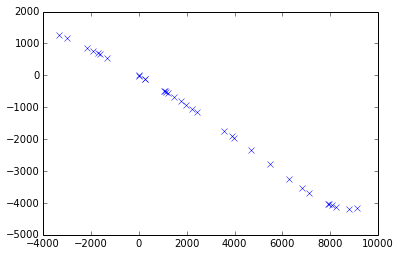

In [388]:
plt.plot(tau,dtau, 'bx')

In [10]:
"""
Find time offsets for all bright enough pulse pairs

Try to see if there is a systematic form in residuals
"""

GPlist = np.loadtxt('gplist_phase_SN20.txt', dtype='string')
Tlist = Time(GPlist[:,0])

n = len(Tlist)
dTlist = np.zeros(n)
tau = np.zeros(n)
dtau = np.zeros(n)

nref_pulse = 7

t1_gp = Tlist[nref_pulse]

p1_ef = read_baseband(t1_gp, 'ef')
p1_jb = read_baseband(t1_gp, 'jb')

for i in range(n):

    t2_gp = Tlist[i]
    print("step %s" % (i))
    if i != nref_pulse:
        p2_ef = read_baseband(t2_gp, 'ef')
        p2_jb = read_baseband(t2_gp, 'jb')
        P1, P2, dpeak1, mbest1, sampdelay1= shift_phase(p1_ef, p1_jb, 32)
        P1, P2, dpeak2, mbest2, sampdelay2= shift_phase(p2_ef, p2_jb, 32)
            
        TDpeak1 = dpeak1*1024*tsamp
        TDsamp1 = -sampdelay1*tsamp
        TDphase1 = mbest1*257 / (128*u.MHz * 2*np.pi)

        TDpeak2 = dpeak2*1024*tsamp
        TDsamp2 = -sampdelay2*tsamp
        TDphase2 = mbest2*257 / (128*u.MHz * 2*np.pi)

        to1 = TDpeak1 + TDsamp1 + TDphase1
        to2 = TDpeak2 + TDsamp2 + TDphase2
        dTmeasured = to2 - to1

        phase1 = pdiff[T==t1_gp][0]
        phase2 = pdiff[T==t2_gp][0]
        dTpredicted = (phase1-phase2)*P/1e-9
            
        tau[i] = t2_gp.unix - t1_gp.unix
        dtau[i] = dTpredicted - dTmeasured.value

step 0
step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20
step 21
step 22
step 23
step 24
step 25
step 26
step 27
step 28
step 29
step 30
step 31
step 32
step 33


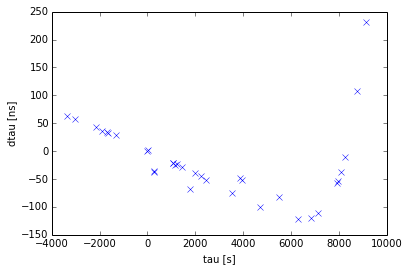

In [11]:
plt.xlabel('tau [s]')
plt.ylabel('dtau [ns]')
plt.plot(tau,dtau, 'bx')

[ -1.99518122e-36   5.58105623e-32  -4.65181036e-28   3.29722892e-25
   1.25684337e-20  -3.63316249e-17  -9.81810789e-14   3.81993865e-10
  -2.29501541e-07  -2.09797157e-02   8.50503427e-01]


(-50, 50)

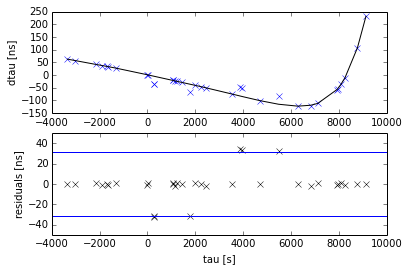

In [13]:
mask = [9,10,16,21,22,24]

tau_fit = np.delete(tau, mask)
dtau_fit = np.delete(dtau, mask)

#tau_fit = 1.*tau
#dtau_fit = 1.*dtau

z = np.polyfit(tau_fit, dtau_fit, 10)
phase_fit = np.poly1d(z)
print(z)

plt.subplot(211)
plt.xlabel('tau [s]')
plt.ylabel('dtau [ns]')
plt.plot(tau,dtau, 'bx')
plt.plot(tau, phase_fit(tau), 'k')

plt.subplot(212)
plt.xlabel('tau [s]')
plt.ylabel('residuals [ns]')
plt.plot(tau, dtau-phase_fit(tau), 'kx')
plt.axhline(31.25)
plt.axhline(-31.25)
plt.ylim(-50,50)

-463526.761673
(<Quantity 1757412.285508517 ns>, <Quantity 1760000.0 ns>, <Quantity -2593.75 ns>, <Quantity 0.006035508517034077 1 / MHz>)
(-1294005.4072268945, 1757412.285508517, -463526.76167259226, -119.88339096982538)
(-41.0, -575.0, -25.842773105483502)


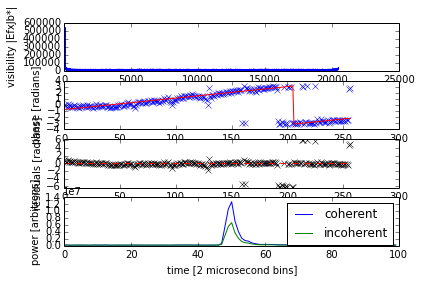

In [187]:
"""
Test phasing on pulse not in list:
"""
%matplotlib inline

t_ref = Time("2015-10-19T00:17:47.415")
# A rather unremarkable S/N = 12 pulse
#t_gp = Time("2015-10-19T00:23:56.897")
t_gp = Time("2015-10-19T01:44:17.690")
t_gp = Time("2015-10-19T01:55:06.340")

phase1 = pdiff[T==t_ref][0]
phase2 = pdiff[T==t_gp][0]
dTpredicted = (phase1-phase2)*P/1e-9

print(dTpredicted)

dTresid = (t_gp.unix - t_ref.unix)
dtauresid = phase_fit(dTresid)

"""
Find reference value's time offset
"""

p_ef = read_baseband(t_ref, 'ef')
p_jb = read_baseband(t_ref, 'jb')

P1, P2, dpeak, mbest, sampdelay = shift_phase(p_ef, p_jb, 32)
            
TDpeak = dpeak*1024*tsamp
TDsamp = -sampdelay*tsamp
TDphase = mbest*257 / (128*u.MHz * 2*np.pi)

t0 = TDpeak + TDsamp + TDphase

print(t0, TDpeak, TDsamp, TDphase)

dT_total = -t0.value - dTpredicted + dtauresid
#dT_total = - dTpredicted + dtauresid

print(dT_total, t0.value, dTpredicted, dtauresid)

incoh_shift = divmod(dT_total , (1024*tsamp.value))[0]
incoh_resid = divmod(dT_total , (1024*tsamp.value))[1]

shifts = divmod(abs(incoh_resid),tsamp.value)

nsamp_shift, resid_shift = shifts[0]*np.sign(dT_total), shifts[1]*np.sign(dT_total)
print(incoh_shift, nsamp_shift, resid_shift)

In [196]:
p_ef = read_baseband(t_gp, 'ef')
p_jb = read_baseband(t_gp, 'jb')

p_jb = np.roll(p_jb, int(incoh_shift), axis=0)

p1d = dechannelize(p_ef)
p2d = dechannelize(p_jb)

nchan = 32

p2d = np.roll(p2d, -int(nsamp_shift), axis=0)
p2 = channelize_ts(p2d, nchan)
p1 = channelize_ts(p1d, nchan)

p1R, p1L = stitch(p1)
p2R, p2L = stitch(p2)

x = np.linspace(0,p1R.shape[1], p1R.shape[1])

m = resid_shift * (128 * 2*np.pi) / 257 / 1000.
print("m", m)

pmodel = phase(x,m,-2.5)
pmodel[0:nchan] *= -1
pmodel[2*nchan:3*nchan] *= -1
pmodel[4*nchan:5*nchan] *= -1
pmodel[6*nchan:7*nchan] *= -1

p2derot = p2R*np.exp(1j*pmodel)[np.newaxis,...]

pRsum = abs(p1R + p2derot)**2.0
pincoh = abs(p1R)**2.0 + abs(p2R)**2.0

%matplotlib qt
plt.plot((abs(p1R)**2.0).sum(-1), label='Effelsberg')
#plt.plot((abs(p2R)**2.0).sum(-1))
plt.plot((abs(p2derot)**2.0).sum(-1), label='Jodrell')

plt.plot(pRsum.sum(-1), label='Coherent Sum')
plt.plot(pincoh.sum(-1), label='Incoherent Sum')
plt.legend()

plt.xlim(7400,7500)
plt.ylabel('Power [arbitrons]')
plt.xlabel('Time [2 microsecond bins]')

('m', -0.080871561599078462)


In [165]:
plt.plot(x, phase(x,m,0))